# Import Important Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.corpus import stopwords

In [3]:
DATA_PATH = '../../data'
stoplist = set(stopwords.words("english"))
stoplist.add("payment")
# stoplist.add("transaction")

# Import Raw Data

In [4]:
raw_data = pd.read_parquet(f'{DATA_PATH}/raw/Transacation_inflows_with_date_3k.pqt')
raw_data.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,METROPOLITAN REG PAYROLL PPD ID: XXXXXXXXXX,2477.02,2022-03-18,PAYCHECK
1,0,acc_0,METROPOLITAN REG VENDOR XXXXXX CCD ID: XXXXXXXXXX,100.00,2022-10-25,EXTERNAL_TRANSFER
2,0,acc_0,ONSTAR SERVICES 888-4ONSTAR MI 08/25,6.29,2022-08-26,MISCELLANEOUS
3,0,acc_0,Zelle payment from CHRISTOPHER J LYONS XXXXXXX...,277.00,2022-06-03,EXTERNAL_TRANSFER
4,0,acc_0,METROPOLITAN REG VENDOR XXXXXX CCD ID: XXXXXXXXXX,100.00,2022-07-29,EXTERNAL_TRANSFER


In [5]:
df = raw_data.copy()
df['memo'] = df['memo'].str.upper()
df.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,METROPOLITAN REG PAYROLL PPD ID: XXXXXXXXXX,2477.02,2022-03-18,PAYCHECK
1,0,acc_0,METROPOLITAN REG VENDOR XXXXXX CCD ID: XXXXXXXXXX,100.00,2022-10-25,EXTERNAL_TRANSFER
2,0,acc_0,ONSTAR SERVICES 888-4ONSTAR MI 08/25,6.29,2022-08-26,MISCELLANEOUS
3,0,acc_0,ZELLE PAYMENT FROM CHRISTOPHER J LYONS XXXXXXX...,277.00,2022-06-03,EXTERNAL_TRANSFER
4,0,acc_0,METROPOLITAN REG VENDOR XXXXXX CCD ID: XXXXXXXXXX,100.00,2022-07-29,EXTERNAL_TRANSFER


In [6]:
def get_text(text, stopwords):
    # first wave text processing
    text = " ".join(re.findall(r"(?!\W|X|\d)(\w+\*\w+|\w+)", text))
    # Primitive removal of ids
    text = re.sub(r"[^\s]*(.)\1{3,}[^\s]*|[^\s]*\d[^\s]*", "", text)
    # Remove single characters
    text = re.sub(r"\s.\s", " ", text)
    # Remove stop words
    text = " ".join([word for word in text.split(" ") if word.lower() not in stopwords])

    return text

memos = df["memo"].apply(lambda x: get_text(x, stoplist))

In [7]:
df["memo"] = memos
df.head()


,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,METROPOLITAN REG PAYROLL PPD ID,2477.02,2022-03-18,PAYCHECK
1,0,acc_0,METROPOLITAN REG VENDOR CCD ID,100.00,2022-10-25,EXTERNAL_TRANSFER
2,0,acc_0,ONSTAR SERVICES ONSTAR MI,6.29,2022-08-26,MISCELLANEOUS
3,0,acc_0,ZELLE CHRISTOPHER LYONS,277.00,2022-06-03,EXTERNAL_TRANSFER
4,0,acc_0,METROPOLITAN REG VENDOR CCD ID,100.00,2022-07-29,EXTERNAL_TRANSFER


# Primitive Income Estimation: Find recurrent transactions

In [8]:
df['posted_date'] = pd.to_datetime(df['posted_date'])
df['year'] = pd.DatetimeIndex(df['posted_date']).year
df['month'] = pd.DatetimeIndex(df['posted_date']).month
df['day'] = pd.DatetimeIndex(df['posted_date']).day
df.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,year,month,day
0,0,acc_0,METROPOLITAN REG PAYROLL PPD ID,2477.02,2022-03-18,PAYCHECK,2022,3,18
1,0,acc_0,METROPOLITAN REG VENDOR CCD ID,100.00,2022-10-25,EXTERNAL_TRANSFER,2022,10,25
2,0,acc_0,ONSTAR SERVICES ONSTAR MI,6.29,2022-08-26,MISCELLANEOUS,2022,8,26
3,0,acc_0,ZELLE CHRISTOPHER LYONS,277.00,2022-06-03,EXTERNAL_TRANSFER,2022,6,3
4,0,acc_0,METROPOLITAN REG VENDOR CCD ID,100.00,2022-07-29,EXTERNAL_TRANSFER,2022,7,29


In [9]:
(
    df
    [df["prism_consumer_id"] == 0]
    .sort_values('month')
    .drop(["prism_consumer_id", "prism_account_id", "posted_date"], axis=1)
).to_csv('../data/test_consumer.csv', index=False)

In [10]:
(
    df
    [df["prism_consumer_id"] == 0]
    .groupby('memo')['amount']
    .agg(['count', 'mean'])
)

,count,mean
memo,,
APPLE COM BILL CA,1,34.150000
ATM CHECK DEPOSIT BAILEY RD CUYAHOGA FALL,2,530.990000
CINCINNATI CLAIM PMT PPD ID,1,2500.000000
DEPOSIT ID NUMBER,1,2313.200000
INTEREST,12,0.043333
IRS TREAS TAX REF PPD ID,1,157.000000
METROPOLITAN REG PAYROLL PPD ID,25,2401.826000
METROPOLITAN REG VENDOR CCD ID,15,142.584000
ONLINE TRANSFER CHK TRANSACTION,1,500.000000


In [11]:
consumer_count_memo = (df
    .groupby(['prism_consumer_id','memo'])['amount']
    .agg(['count', 'sum'])
)

consumer_memo_sig = consumer_count_memo[consumer_count_memo['count'] > 3]
consumer_memo_sig

count  \
prism_consumer_id memo                                                        
0                 INTEREST                                               12   
                  METROPOLITAN REG PAYROLL PPD ID                        25   
                  METROPOLITAN REG VENDOR CCD ID                         15   
                  ZELLE BRENNA GRIMES                                    10   
                  ZELLE CHRISTOPHER LYONS                                 9   
...                                                                     ...   
5941              ACH DEPOSIT RAISER TYPE EDI PAYMNT DATA  CO RAI...     18   
                  POS DEPOSITUBER HOWARD ST SAN FRANCISCO CA CARD...    193   
                  POS DEPOSITUBER HOWARD ST SAN FRANCISCO CA CARD...     45   
                  ULTRABRANCH PC TRANSFER SHARE                           6   
                  ULTRABRANCH PC TRANSFERFROM OVERLAND MAUREEN SHARE     23   

                                                                           sum  
prism_consumer_id memo                                                          
0                 INTEREST                                                0.52  
                  METROPOLITAN REG PAYROLL PPD ID                     60045.65  
                  METROPOLITAN REG VENDOR CCD ID                       2138.76  
                  ZELLE BRENNA GRIMES                                   755.00  
                  ZELLE CHRISTOPHER LYONS                              1686.00  
...                                                                        ...  
5941              ACH DEPOSIT RAISER TYPE EDI PAYMNT DATA  CO RAI...   1097.00  
                  POS DEPOSITUBER HOWARD ST SAN FRANCISCO CA CARD...  33503.33  
                  POS DEPOSITUBER HOWARD ST SAN FRANCISCO CA CARD...  11071.61  
                  ULTRABRANCH PC TRANSFER SHARE                        2305.00  
                  ULTRABRANCH PC TRANSFERFROM OVERLAND MAUREEN SHARE   6910.00  

[22236 rows x 2 columns]

In [12]:
consumer_memo_sig.groupby('prism_consumer_id').sum()

,count,sum
prism_consumer_id,,
0,71,64625.93
2,98,102902.00
4,105,410718.92
7,113,230249.15
9,343,193960.47
...,...,...
5930,191,117137.63
5935,79,12785.62
5939,74,23330.71


In [13]:
cons_date_range = df[['prism_consumer_id', 'posted_date']].groupby('prism_consumer_id').agg(lambda x: (np.max(x) - np.min(x)))['posted_date'].dt.days

In [14]:
cons_prim_yearly_income = consumer_memo_sig.groupby('prism_consumer_id').sum()['sum'] / cons_date_range * 365
cons_prim_yearly_income.head()

prism_consumer_id
0     66634.080367
2    104331.194444
4    414122.667956
7    240116.970714
9     70373.331561
dtype: float64

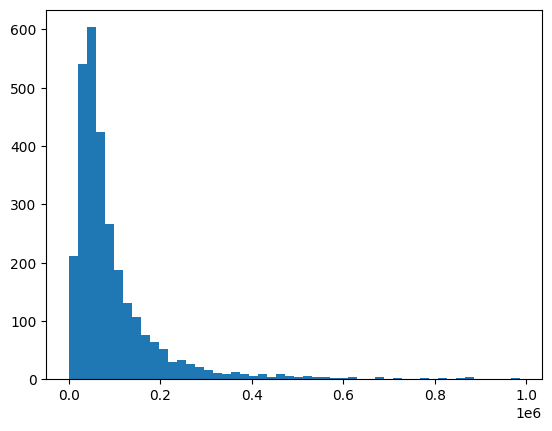

In [15]:
plt.hist(cons_prim_yearly_income[cons_prim_yearly_income < 1 * 10 ** 6], bins=50);

In [16]:
cons_prim_yearly_income[cons_prim_yearly_income > 1 * 10 ** 6]

prism_consumer_id
37      6.524814e+06
158     4.144608e+06
326     1.004782e+06
489     2.575953e+06
539     1.022186e+06
561     1.725923e+06
650     2.347671e+06
660     1.248353e+06
664     1.028752e+06
885     1.062237e+06
1085    1.082570e+06
1094    2.771352e+06
1232    2.496242e+06
1288    1.731108e+06
1308    3.889265e+06
1378    1.037646e+06
1433    1.064108e+06
1731    1.101574e+06
1769    1.869265e+06
4901    2.186060e+06
dtype: float64

In [17]:
df['age'] = np.max(df['posted_date']) - df['posted_date']
df.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,year,month,day,age
0,0,acc_0,METROPOLITAN REG PAYROLL PPD ID,2477.02,2022-03-18,PAYCHECK,2022,3,18,501 days
1,0,acc_0,METROPOLITAN REG VENDOR CCD ID,100.00,2022-10-25,EXTERNAL_TRANSFER,2022,10,25,280 days
2,0,acc_0,ONSTAR SERVICES ONSTAR MI,6.29,2022-08-26,MISCELLANEOUS,2022,8,26,340 days
3,0,acc_0,ZELLE CHRISTOPHER LYONS,277.00,2022-06-03,EXTERNAL_TRANSFER,2022,6,3,424 days
4,0,acc_0,METROPOLITAN REG VENDOR CCD ID,100.00,2022-07-29,EXTERNAL_TRANSFER,2022,7,29,368 days


In [18]:
cons_age = (df
    .groupby(['prism_consumer_id','memo'])[['amount','age']]
    .agg(['count', 'sum', 'mean', 'median', 'std', 'min', 'max'])
)
# cons_age = cons_age[cons_age['count'] > 1]
cons_age.head()

amount           \
                                                             count      sum   
prism_consumer_id memo                                                        
0                 APPLE COM BILL CA                              1    34.15   
                  ATM CHECK DEPOSIT BAILEY RD CUYAHOGA FALL      2  1061.98   
                  CINCINNATI CLAIM PMT PPD ID                    1  2500.00   
                  DEPOSIT ID NUMBER                              1  2313.20   
                  INTEREST                                      12     0.52   

                                                                          \
                                                                    mean   
prism_consumer_id memo                                                     
0                 APPLE COM BILL CA                            34.150000   
                  ATM CHECK DEPOSIT BAILEY RD CUYAHOGA FALL   530.990000   
                  CINCINNATI CLAIM PMT PPD ID                2500.000000   
                  DEPOSIT ID NUMBER                          2313.200000   
                  INTEREST                                      0.043333   

                                                                      \
                                                              median   
prism_consumer_id memo                                                 
0                 APPLE COM BILL CA                            34.15   
                  ATM CHECK DEPOSIT BAILEY RD CUYAHOGA FALL   530.99   
                  CINCINNATI CLAIM PMT PPD ID                2500.00   
                  DEPOSIT ID NUMBER                          2313.20   
                  INTEREST                                      0.04   

                                                                       \
                                                                  std   
prism_consumer_id memo                                                  
0                 APPLE COM BILL CA                               NaN   
                  ATM CHECK DEPOSIT BAILEY RD CUYAHOGA FALL  9.206530   
                  CINCINNATI CLAIM PMT PPD ID                     NaN   
                  DEPOSIT ID NUMBER                               NaN   
                  INTEREST                                   0.004924   

                                                                               \
                                                                 min      max   
prism_consumer_id memo                                                          
0                 APPLE COM BILL CA                            34.15    34.15   
                  ATM CHECK DEPOSIT BAILEY RD CUYAHOGA FALL   524.48   537.50   
                  CINCINNATI CLAIM PMT PPD ID                2500.00  2500.00   
                  DEPOSIT ID NUMBER                          2313.20  2313.20   
                  INTEREST                                      0.04     0.05   

                                                              age            \
                                                            count       sum   
prism_consumer_id memo                                                        
0                 APPLE COM BILL CA                             1  371 days   
                  ATM CHECK DEPOSIT BAILEY RD CUYAHOGA FALL     2  681 days   
                  CINCINNATI CLAIM PMT PPD ID                   1  435 days   
                  DEPOSIT ID NUMBER                             1  452 days   
                  INTEREST                                     12 4351 days   

                                                                               \
                                                                         mean   
prism_consumer_id memo                                                          
0                 APPLE COM BILL CA                         371 days 00:00:00   
                  ATM CHECK DEPOSIT BAILEY RD CUYA

In [19]:
rand_id = np.random.choice(df['prism_consumer_id'].unique())
cons_age.loc[rand_id]

amount            \
                                                    count       sum   
memo                                                                  
ACH DEPOSIT COMPANY ADRIANA TORRES ENTRY ACH FE...      2     11.50   
ACH DEPOSIT COMPANY ALBERT ENTRY SAVINGS ADRIAN...      2      1.06   
ACH DEPOSIT COMPANY COMPA INDUSTRIES ENTRY DIRE...     12  22391.88   
ACH DEPOSIT COMPANY COMPA INDUSTRIES ENTRY DIRE...      1   1872.29   
ACH DEPOSIT COMPANY DAVE COM ENTRY  AUTOMATED A...      2      1.10   
ACH DEPOSIT COMPANY DAVE INC ENTRY CREDIT ADRIA...      2      0.05   
ACH DEPOSIT COMPANY EARNIN ENTRY ADRIANA TORRES         3    250.00   
ACH DEPOSIT COMPANY FID BKG SVC LLC ENTRY MONEY...      1     17.53   
ACH DEPOSIT COMPANY KLOVER APP BOOST ENTRY KLVA...      1    120.00   
ACH DEPOSIT COMPANY RUSH STREET INTR ENTRY BETR...     15   6320.00   
ALBERT CORPORATION DEPOSIT                              1     75.00   
BRIGIT DEPOSIT                                          3     50.02   
CAPITAL ONE DEPOSIT                                     2      0.11   
CASH APP DEPOSIT                                        4     96.26   
CHECK DEPOSIT REMOTE DEPOSIT                            2    882.59   
DAVE INC DEPOSIT                                        3    325.00   
DEBIT DEPOSIT DAVE COM VISA DIRECT                      1     26.00   
DEBIT DEPOSIT KLOVER PLUS                               1      0.01   
DEPOSIT KLOVER PLUS GRAND AVE                           2      0.05   
DEPOSIT TRANSFER  OVERDRAFT TRANSFER                    2    200.88   
EARNIN DEPOSIT                                          4    300.00   
EMPOWER FINANCE INC DEPOSIT                            10    750.00   
ONLINE BANKING DEPOSIT TRANSFER                         5   1250.00   
TRANSFER EARNIN                                        15   1270.00   
VENMO                                                   8    379.87   

                                                                           \
                                                           mean    median   
memo                                                                        
ACH DEPOSIT COMPANY ADRIANA TORRES ENTRY ACH FE...     5.750000     5.750   
ACH DEPOSIT COMPANY ALBERT ENTRY SAVINGS ADRIAN...     0.530000     0.530   
ACH DEPOSIT COMPANY COMPA INDUSTRIES ENTRY DIRE...  1865.990000  1851.440   
ACH DEPOSIT COMPANY COMPA INDUSTRIES ENTRY DIRE...  1872.290000  1872.290   
ACH DEPOSIT COMPANY DAVE COM ENTRY  AUTOMATED A...     0.550000     0.550   
ACH DEPOSIT COMPANY DAVE INC ENTRY CREDIT ADRIA...     0.025000     0.025   
ACH DEPOSIT COMPANY EARNIN ENTRY ADRIANA TORRES       83.333333   100.000   
ACH DEPOSIT COMPANY FID BKG SVC LLC ENTRY MONEY...    17.530000    17.530   
ACH DEPOSIT COMPANY KLOVER APP BOOST ENTRY KLVA...   120.000000   120.000   
ACH DEPOSIT COMPANY RUSH STREET INTR ENTRY BETR...   421.333333   300.000   
ALBERT CORPORATION DEPOSIT                            75.000000    75.000   
BRIGIT DEPOSIT                                        16.673333     0.010   
CAPITAL ONE DEPOSIT                                    0.055000     0.055   
CASH APP DEPOSIT                                      24.065000    19.650   
CHECK DEPOSIT REMOTE DEPOSIT                         441.295000   441.295   
DAVE INC DEPOSIT                                     108.333333   125.000   
DEBIT DEPOSIT DAVE COM VISA DIRECT                    26.000000    26.000   
DEBIT DEPOSIT KLOVER PLUS                              0.010000     0.010   
DEPOSIT KLOVER PLUS GRAND AVE                          0.025000     0.025   
DEPOSIT TRANSFER  OVERDRAFT TRANSFER                 100.440000   100.440   
EARNIN DEPOSIT                                        75.000000    75.000   
EMPOWER FINANCE INC DEPOSIT                           75.000000    75.000   
ONLINE BANKING DEPOSIT TRANSFER                      250.000000    50.000   
TRANSFER EARNIN                                       84.666

In [21]:
# plt.hist(cons_age['std'].dt.days, bins = 50);

In [22]:
df[df['category'] == 'DEPOSIT']

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,year,month,day,age
23,0,acc_0,ATM CHECK DEPOSIT BAILEY RD CUYAHOGA FALL,537.50,2022-08-08,DEPOSIT,2022,8,8,358 days
49,0,acc_0,DEPOSIT ID NUMBER,2313.20,2022-05-06,DEPOSIT,2022,5,6,452 days
52,0,acc_0,ATM CHECK DEPOSIT BAILEY RD CUYAHOGA FALL,524.48,2022-09-12,DEPOSIT,2022,9,12,323 days
151,2,acc_3,ATM CHECK DEPOSIT STEPHANIE STE HENDERSON NV A...,19.00,2021-04-08,DEPOSIT,2021,4,8,845 days
161,2,acc_3,ATM CHECK DEPOSIT STEPHANIE ST STE HENDERSON N...,320.00,2021-10-25,DEPOSIT,2021,10,25,645 days
...,...,...,...,...,...,...,...,...,...,...
1035528,5940,acc_9523,DEPOSIT ATM ARROWHEAD CREDIT UNION VICT AMARGO...,225.00,2023-01-24,DEPOSIT,2023,1,24,189 days
1035535,5940,acc_9523,DEPOSIT DEBIT CARD FLOATME FUND CR SAN ANTONIO TX,20.00,2023-01-31,DEPOSIT,2023,1,31,182 days
1035537,5940,acc_9523,DEPOSIT ATM ARROWHEAD CREDIT UNION VICT AMARGO...,275.00,2023-01-31,DEPOSIT,2023,1,31,182 days
1035598,5941,acc_9524,ATM DEPOSITALASKA USA EAST JUANITA AVE MESA AZ...,130.00,2022-08-18,DEPOSIT,2022,8,18,348 days


In [23]:
df["delta_age"] = (
    (
        df.sort_values(['posted_date']).groupby(['prism_consumer_id','memo'])['posted_date'].shift(-1) - 
        df.sort_values(['posted_date'])['posted_date']
    )
    .dt.days
    .fillna(0)
)
df[(df['prism_consumer_id'] == 0)].sort_values(['posted_date'])

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,year,month,day,age,delta_age
73,0,acc_0,SOFI PL DISB PL DISB WEB ID,37000.00,2022-02-14,EXTERNAL_TRANSFER,2022,2,14,533 days,0.0
14,0,acc_1,INTEREST,0.04,2022-02-17,INVESTMENT_INCOME,2022,2,17,530 days,28.0
27,0,acc_0,METROPOLITAN REG PAYROLL PPD ID,2331.71,2022-02-18,PAYCHECK,2022,2,18,529 days,14.0
18,0,acc_0,ZELLE CHRISTOPHER LYONS,25.00,2022-02-18,EXTERNAL_TRANSFER,2022,2,18,529 days,27.0
20,0,acc_0,ZELLE BRENNA GRIMES,75.00,2022-02-24,EXTERNAL_TRANSFER,2022,2,24,523 days,27.0
...,...,...,...,...,...,...,...,...,...,...,...
7,0,acc_1,INTEREST,0.04,2023-01-20,INVESTMENT_INCOME,2023,1,20,193 days,0.0
17,0,acc_0,METROPOLITAN REG PAYROLL PPD ID,2547.35,2023-01-20,PAYCHECK,2023,1,20,193 days,14.0
26,0,acc_0,METROPOLITAN REG VENDOR CCD ID,100.00,2023-01-20,EXTERNAL_TRANSFER,2023,1,20,193 days,0.0
62,0,acc_0,ZELLE BRENNA HEIDENREICH,97.00,2023-01-27,EXTERNAL_TRANSFER,2023,1,27,186 days,0.0


In [24]:
cons_dage = (df
    .groupby(['prism_consumer_id','memo'])[['delta_age', 'amount']]
    .agg(['count', 'sum', 'mean', 'median', 'std', 'min', 'max'])
)
cons_dage = cons_dage[cons_dage['delta_age']['count'] > 1]
cons_dage.head()

delta_age         \
                                                                count    sum   
prism_consumer_id memo                                                         
0                 ATM CHECK DEPOSIT BAILEY RD CUYAHOGA FALL         2   35.0   
                  INTEREST                                         12  337.0   
                  METROPOLITAN REG PAYROLL PPD ID                  25  350.0   
                  METROPOLITAN REG VENDOR CCD ID                   15  329.0   
                  ZELLE BRENNA GRIMES                              10  277.0   

                                                                               \
                                                                  mean median   
prism_consumer_id memo                                                          
0                 ATM CHECK DEPOSIT BAILEY RD CUYAHOGA FALL  17.500000   17.5   
                  INTEREST                                   28.083333   30.0   
                  METROPOLITAN REG PAYROLL PPD ID            14.000000   15.0   
                  METROPOLITAN REG VENDOR CCD ID             21.933333   28.0   
                  ZELLE BRENNA GRIMES                        27.700000   29.0   

                                                                             \
                                                                   std  min   
prism_consumer_id memo                                                        
0                 ATM CHECK DEPOSIT BAILEY RD CUYAHOGA FALL  24.748737  0.0   
                  INTEREST                                    9.070014  0.0   
                  METROPOLITAN REG PAYROLL PPD ID             3.840573  0.0   
                  METROPOLITAN REG VENDOR CCD ID             12.446839  0.0   
                  ZELLE BRENNA GRIMES                        10.822302  0.0   

                                                                  amount  \
                                                              max  count   
prism_consumer_id memo                                                     
0                 ATM CHECK DEPOSIT BAILEY RD CUYAHOGA FALL  35.0      2   
                  INTEREST                                   34.0     12   
                  METROPOLITAN REG PAYROLL PPD ID            18.0     25   
                  METROPOLITAN REG VENDOR CCD ID             35.0     15   
                  ZELLE BRENNA GRIMES                        41.0     10   

                                                                       \
                                                                  sum   
prism_consumer_id memo                                                  
0                 ATM CHECK DEPOSIT BAILEY RD CUYAHOGA FALL   1061.98   
                  INTEREST                                       0.52   
                  METROPOLITAN REG PAYROLL PPD ID            60045.65   
                  METROPOLITAN REG VENDOR CCD ID              2138.76   
                  ZELLE BRENNA GRIMES                          755.00   

                                                                          \
                                                                    mean   
prism_consumer_id memo                                                     
0                 ATM CHECK DEPOSIT BAILEY RD CUYAHOGA FALL   530.990000   
                  INTEREST                                      0.043333   
                  METROPOLITAN REG PAYROLL PPD ID            2401.826000   
                  METROPOLITAN REG VENDOR CCD ID              142.584000   
                  ZELLE BRENNA GRIMES                          75.500000   

                                                                      \
                                                              median   
prism_consumer_id memo                                                 
0                 ATM CHECK DEPOSIT BAILEY RD CUYAHOGA FALL   530.99   
                  INTEREST                    

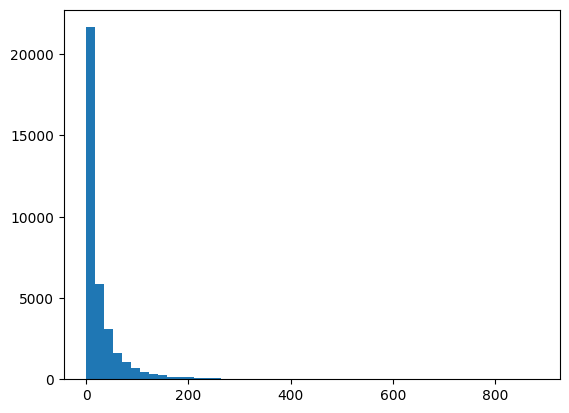

In [25]:
plt.hist(cons_dage['delta_age']['std'], bins = 50);

In [26]:
# print(np.max(cons_dage["mean"]))
# cons_dage.iloc[np.argmax(cons_dage["mean"]) - 5: np.argmax(cons_dage["mean"]) + 5]

Text(0, 0.5, 'count')

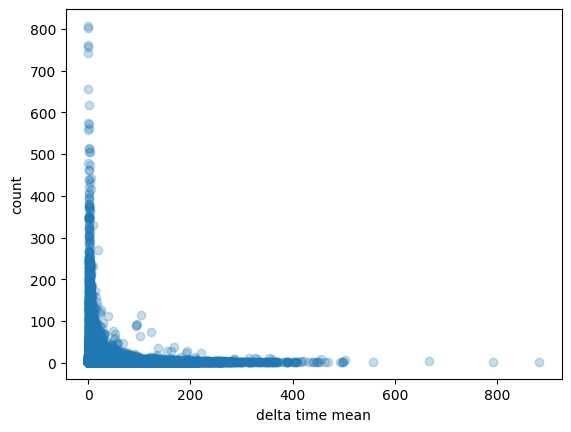

In [31]:
plt.scatter(y = (cons_dage['delta_age']['count']), x = (cons_dage['delta_age']['std']), alpha = 0.25)
plt.xlabel("delta time mean")
plt.ylabel("count")

In [32]:
cons_income_dage = cons_dage[(cons_dage['delta_age']['std'] > 10) & (cons_dage['delta_age']['std'] < 300)]['amount'].groupby(level=0).sum()['sum']
# cons_income_dage = cons_income_dage / cons_date_range * 365
cons_income_dage

prism_consumer_id
0         5957.74
2        63404.49
4       233638.82
7       144172.02
9       156003.24
          ...    
5930     55435.59
5935      4349.12
5939      6500.00
5940      8035.39
5941      2896.53
Name: sum, Length: 2830, dtype: float64

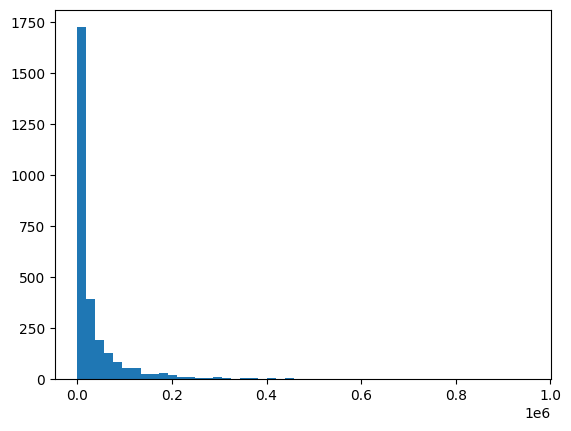

In [35]:
plt.hist(cons_income_dage[cons_income_dage < 1 * 10 ** 6], bins=50);

In [34]:
# plt.hist(cons_prim_yearly_income[cons_prim_yearly_income < 1 * 10 ** 6], bins=50);
for x,y in list(zip(cons_prim_yearly_income, cons_income_dage)):
    print(f"{x:.2f} \t {y:.2f}")

66634.08 	 5957.74
104331.19 	 63404.49
414122.67 	 233638.82
240116.97 	 144172.02
70373.33 	 156003.24
80381.81 	 9.02
274112.03 	 152757.44
196745.69 	 46741.20
125491.50 	 125713.75
52472.72 	 13170.26
203224.13 	 99796.20
133274.75 	 769.52
802304.11 	 729548.01
92220.77 	 700.00
71503.98 	 7817.70
145986.91 	 61424.32
103529.78 	 36969.25
111228.88 	 24912.85
64772.35 	 5393.78
116587.64 	 7431.54
81634.44 	 5716.57
83669.95 	 47.15
6524813.60 	 3050838.77
235350.68 	 190867.21
88911.18 	 18352.71
291214.65 	 178009.53
20580.35 	 847.50
147392.79 	 32964.44
45189.40 	 26801.64
75835.40 	 7598.40
261155.00 	 104229.74
365492.69 	 75965.00
40471.81 	 987.53
155902.93 	 36380.97
67268.45 	 13435.55
126335.90 	 38051.66
108818.97 	 45109.25
313993.29 	 325035.91
156997.76 	 68405.74
62415.07 	 5065.11
13845.64 	 5508.99
386348.23 	 258396.50
172817.24 	 114367.31
378000.33 	 370907.66
97719.62 	 87325.69
98250.62 	 10185.55
217290.79 	 75763.08
194071.36 	 60002.09
14151.79 	 16111.6